### Spark notebook ###

This notebook will only work in a Jupyter session running on `mathmadslinux2p`.

You can start your own Jupyter session on `mathmadslinux2p` and open this notebook in Chrome on the MADS Windows server by

**Steps**

1. Login to the MADS Windows server using https://mathportal.canterbury.ac.nz/.
2. Download or copy this notebook to your home directory.
3. Open powershell and run `ssh mathmadslinux2p`.
4. Run `start_pyspark_notebook` or `/opt/anaconda3/bin/jupyter-notebook --ip 132.181.129.68 --port $((8000 + $((RANDOM % 999))))`.
5. Copy / paste the url provided in the shell window into Chrome on the MADS Windows server.
6. Open the notebook from the Jupyter root directory (which is your home directory).
7. Run `start_spark()` to start a spark session in the notebook.
8. Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the Spark UI.

In [63]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

### Example notebook ###

The code below provides a template for how you would use a notebook to start spark, run some code, and then stop spark.

**Steps**

- Run `start_spark()` to start a spark session in the notebook (only change the default resources when advised to do so for an exercise or assignment)
- Write and run code interactively, creating additional cells as needed.
- Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the [Spark UI](http://mathmadslinux2p.canterbury.ac.nz:8080/).

In [64]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)

spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.driver.memory,4g
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.sql.warehouse.dir,file:/users/home/yya163/DATA420_lab/Assignment_1/spark-warehouse
spark.executor.cores,2
spark.driver.host,mathmadslinux2p.canterbury.ac.nz
spark.sql.shuffle.partitions,32
spark.ui.port,4594


In [65]:
# Import needed modules

from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import SparkSession

# Processing

## Q1(a)

In [4]:
# List the Directory Structure
!hdfs dfs -ls hdfs:///data/ghcnd

Found 5 items
drwxr-xr-x   - jsw93 jsw93          0 2024-08-21 12:34 hdfs:///data/ghcnd/daily
-rw-r--r--   8 jsw93 jsw93       3659 2024-08-13 14:44 hdfs:///data/ghcnd/ghcnd-countries.txt
-rw-r--r--   8 jsw93 jsw93   34791732 2024-08-13 14:44 hdfs:///data/ghcnd/ghcnd-inventory.txt
-rw-r--r--   8 jsw93 jsw93       1086 2024-08-13 14:44 hdfs:///data/ghcnd/ghcnd-states.txt
-rw-r--r--   8 jsw93 jsw93   11007484 2024-08-13 14:44 hdfs:///data/ghcnd/ghcnd-stations.txt


In [5]:
!hdfs dfs -ls hdfs:///data/ghcnd/daily

Found 263 items
-rw-r--r--   8 jsw93 jsw93    1897634 2024-08-07 01:43 hdfs:///data/ghcnd/daily/1750.csv.gz
-rw-r--r--   8 jsw93 jsw93       3358 2024-08-07 01:44 hdfs:///data/ghcnd/daily/1763.csv.gz
-rw-r--r--   8 jsw93 jsw93       3327 2024-08-07 01:42 hdfs:///data/ghcnd/daily/1764.csv.gz
-rw-r--r--   8 jsw93 jsw93       3335 2024-08-07 01:41 hdfs:///data/ghcnd/daily/1765.csv.gz
-rw-r--r--   8 jsw93 jsw93       3344 2024-08-07 01:38 hdfs:///data/ghcnd/daily/1766.csv.gz
-rw-r--r--   8 jsw93 jsw93       3356 2024-08-07 01:43 hdfs:///data/ghcnd/daily/1767.csv.gz
-rw-r--r--   8 jsw93 jsw93       3325 2024-08-07 01:41 hdfs:///data/ghcnd/daily/1768.csv.gz
-rw-r--r--   8 jsw93 jsw93       3418 2024-08-07 01:41 hdfs:///data/ghcnd/daily/1769.csv.gz
-rw-r--r--   8 jsw93 jsw93       3357 2024-08-07 01:43 hdfs:///data/ghcnd/daily/1770.csv.gz
-rw-r--r--   8 jsw93 jsw93       3373 2024-08-07 01:43 hdfs:///data/ghcnd/daily/1771.csv.gz
-rw-r--r--   8 jsw93 jsw93       3419 2024-08-07 01:42 hdfs:///d

## Q1(b)

In [6]:
!hdfs dfs -du -h hdfs:///data/ghcnd/daily

1.8 M    14.5 M    hdfs:///data/ghcnd/daily/1750.csv.gz
3.3 K    26.2 K    hdfs:///data/ghcnd/daily/1763.csv.gz
3.2 K    26.0 K    hdfs:///data/ghcnd/daily/1764.csv.gz
3.3 K    26.1 K    hdfs:///data/ghcnd/daily/1765.csv.gz
3.3 K    26.1 K    hdfs:///data/ghcnd/daily/1766.csv.gz
3.3 K    26.2 K    hdfs:///data/ghcnd/daily/1767.csv.gz
3.2 K    26.0 K    hdfs:///data/ghcnd/daily/1768.csv.gz
3.3 K    26.7 K    hdfs:///data/ghcnd/daily/1769.csv.gz
3.3 K    26.2 K    hdfs:///data/ghcnd/daily/1770.csv.gz
3.3 K    26.4 K    hdfs:///data/ghcnd/daily/1771.csv.gz
3.3 K    26.7 K    hdfs:///data/ghcnd/daily/1772.csv.gz
3.3 K    26.3 K    hdfs:///data/ghcnd/daily/1773.csv.gz
3.3 K    26.5 K    hdfs:///data/ghcnd/daily/1774.csv.gz
6.2 K    49.7 K    hdfs:///data/ghcnd/daily/1775.csv.gz
6.3 K    50.2 K    hdfs:///data/ghcnd/daily/1776.csv.gz
6.3 K    50.2 K    hdfs:///data/ghcnd/daily/1777.csv.gz
6.1 K    48.8 K    hdfs:///data/ghcnd/daily/1778.csv.gz
6 K      48 K      hdfs:///data/ghcnd/daily/1779

In [58]:
import pandas as pd

# Load the CSV into DataFrame
df = pd.read_csv('dailysize.csv')
df.head()

,Compressed Size,Size,Files
0,1.8 M,14.5 M,hdfs:///data/ghcnd/daily/1750.csv.gz
1,237,1.9 K,hdfs:///data/ghcnd/daily/1751.csv.gz
2,237,1.9 K,hdfs:///data/ghcnd/daily/1752.csv.gz
3,237,1.9 K,hdfs:///data/ghcnd/daily/1753.csv.gz
4,237,1.9 K,hdfs:///data/ghcnd/daily/1754.csv.gz


In [66]:
# Define a function to convert sizes 
def convert_size(size_str):
    size_str = size_str.strip()
    if size_str[-1] == 'K':
        return float(size_str[:-1]) * 1024
    elif size_str[-1] == 'M':
        return float(size_str[:-1]) * 1024 * 1024
    elif size_str[-1] == 'G':
        return float(size_str[:-1]) * 1024 * 1024 * 1024
    else:
        return float(size_str)

# Apply the conversion 
df['Compressed Size (Bytes)'] = df['Compressed Size'].apply(convert_size)
df['Size (Bytes)'] = df['Size'].apply(convert_size)

# Check the result
df.head()


,Compressed Size,Size,Files,Year,Compressed Size (Bytes),Size (Bytes)
0,1.8 M,14.5 M,hdfs:///data/ghcnd/daily/1750.csv.gz,1750,1887436.8,15204352.0
1,237,1.9 K,hdfs:///data/ghcnd/daily/1751.csv.gz,1751,237.0,1945.6
2,237,1.9 K,hdfs:///data/ghcnd/daily/1752.csv.gz,1752,237.0,1945.6
3,237,1.9 K,hdfs:///data/ghcnd/daily/1753.csv.gz,1753,237.0,1945.6
4,237,1.9 K,hdfs:///data/ghcnd/daily/1754.csv.gz,1754,237.0,1945.6


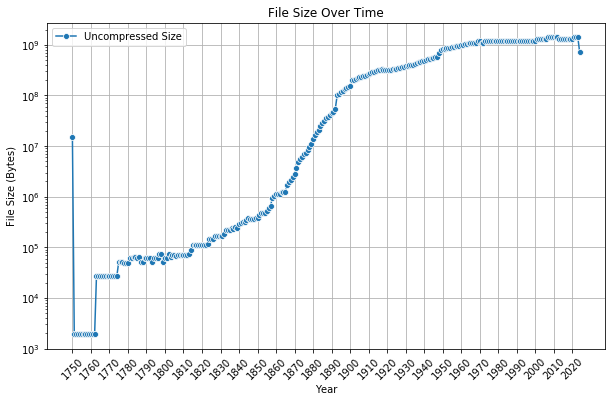

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the year
df['Year'] = df['Files'].str.extract(r'/daily/(\d+)\.csv\.gz').astype(int)

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Year', y='Size (Bytes)', marker='o', label='Uncompressed Size')

# Set the Y-axis to logarithmic scale
plt.yscale('log')

plt.title('File Size Over Time')
plt.xlabel('Year')
plt.ylabel('File Size (Bytes)')

# Show every 10 years
start_year = df['Year'].min()
end_year = df['Year'].max()
plt.xticks(range(start_year, end_year + 1, 10), rotation=45)

# Add a legend and grid
plt.legend()
plt.grid(True)

plt.savefig('daily_file_size.png')
plt.show()

## Q1(c)

In [10]:
!hdfs dfs -du -h hdfs:///data/ghcnd

12.4 G  99.5 G   hdfs:///data/ghcnd/daily
3.6 K   28.6 K   hdfs:///data/ghcnd/ghcnd-countries.txt
33.2 M  265.4 M  hdfs:///data/ghcnd/ghcnd-inventory.txt
1.1 K   8.5 K    hdfs:///data/ghcnd/ghcnd-states.txt
10.5 M  84.0 M   hdfs:///data/ghcnd/ghcnd-stations.txt


## Q2(a)-(c)

In [11]:
# Define the Daily Schema

daily_schema = StructType([
    StructField("ID", StringType(), True),
    StructField("Date", StringType(), True), 
    StructField("Element", StringType(), True),
    StructField("Value", IntegerType(), True),
    StructField("MeasurementFlag", StringType(), True),
    StructField("QualityFlag", StringType(), True),
    StructField("SourceFlag", StringType(), True),
    StructField("ObservationTime", StringType(), True)
])

# Get the whole daily dataframe
daily_df = spark.read.csv("hdfs:///data/ghcnd/daily", schema=daily_schema, header=False)

In [12]:
# Define 2023 daily data
daily_df_2023 = spark.read.csv("hdfs:///data/ghcnd/daily/2023.csv.gz", schema=daily_schema, header=False)

# Limit the DataFrame to 1,000 rows
limited_daily_df = daily_df_2023.limit(1000)

show_as_html(limited_daily_df)

,ID,Date,Element,Value,MeasurementFlag,QualityFlag,SourceFlag,ObservationTime
0,AE000041196,20230101,TMAX,252,None,None,S,None
1,AE000041196,20230101,TMIN,149,None,None,S,None
2,AE000041196,20230101,PRCP,0,D,None,S,None
3,AE000041196,20230101,TAVG,207,H,None,S,None
4,AEM00041194,20230101,TMAX,255,None,None,S,None
5,AEM00041194,20230101,TMIN,186,None,None,S,None
6,AEM00041194,20230101,PRCP,0,None,None,S,None
7,AEM00041194,20230101,TAVG,223,H,None,S,None
8,AEM00041217,20230101,TMAX,248,None,None,S,None
9,AEM00041217,20230101,TMIN,184,None,None,S,None


## Q2(d)

In [39]:
# Load the metadata files
stations_raw = spark.read.text("hdfs:///data/ghcnd/ghcnd-stations.txt")
countries_raw = spark.read.text("hdfs:///data/ghcnd/ghcnd-countries.txt")
states_raw = spark.read.text("hdfs:///data/ghcnd/ghcnd-states.txt")
inventory_raw = spark.read.text("hdfs:///data/ghcnd/ghcnd-inventory.txt")

In [40]:
from pyspark.sql.functions import substring, trim

# Load stations dataset
stations_df = stations_raw.select(
    trim(substring("value", 1, 11)).alias("ID"),
    substring("value", 13, 8).alias("Latitude").cast("double"),
    substring("value", 22, 9).alias("Longitude").cast("double"),
    substring("value", 32, 6).alias("Elevation").cast("double"),
    trim(substring("value", 39, 2)).alias("State"),
    trim(substring("value", 42, 30)).alias("Name"),
    trim(substring("value", 73, 3)).alias("GSN_Flag"),
    trim(substring("value", 77, 3)).alias("HCN_CRN_Flag"),
    trim(substring("value", 81, 5)).alias("WMO_ID")
)

# Load countries dataset 
countries_df = countries_raw.select(
    trim(substring("value", 1, 2)).alias("Code"),
    trim(substring("value", 4, 61)).alias("Name")
)

# Load states dataset 
states_df = states_raw.select(
    trim(substring("value", 1, 2)).alias("Code"),
    trim(substring("value", 4, 47)).alias("Name")
)

# Load inventory dataset 
inventory_df = inventory_raw.select(
    trim(substring("value", 1, 11)).alias("ID"),
    substring("value", 13, 8).alias("Latitude").cast("double"),
    substring("value", 22, 9).alias("Longitude").cast("double"),
    trim(substring("value", 32, 4)).alias("Element"),
    trim(substring("value", 37, 4)).alias("FirstYear"),
    trim(substring("value", 42, 4)).alias("LastYear")
)

# Display
show_as_html(stations_df)
show_as_html(countries_df)
show_as_html(states_df)
show_as_html(inventory_df)

,ID,Latitude,Longitude,Elevation,State,Name,GSN_Flag,HCN_CRN_Flag,WMO_ID
0,ACW00011604,17.1167,-61.7833,10.1,,ST JOHNS COOLIDGE FLD,,,
1,ACW00011647,17.1333,-61.7833,19.2,,ST JOHNS,,,
2,AE000041196,25.3330,55.5170,34.0,,SHARJAH INTER. AIRP,GSN,,41196
3,AEM00041194,25.2550,55.3640,10.4,,DUBAI INTL,,,41194
4,AEM00041217,24.4330,54.6510,26.8,,ABU DHABI INTL,,,41217
5,AEM00041218,24.2620,55.6090,264.9,,AL AIN INTL,,,41218
6,AF000040930,35.3170,69.0170,3366.0,,NORTH-SALANG,GSN,,40930
7,AFM00040938,34.2100,62.2280,977.2,,HERAT,,,40938
8,AFM00040948,34.5660,69.2120,1791.3,,KABUL INTL,,,40948
9,AFM00040990,31.5000,65.8500,1010.0,,KANDAHAR AIRPORT,,,40990


,Code,Name
0,AC,Antigua and Barbuda
1,AE,United Arab Emirates
2,AF,Afghanistan
3,AG,Algeria
4,AJ,Azerbaijan
5,AL,Albania
6,AM,Armenia
7,AO,Angola
8,AQ,American Samoa [United States]
9,AR,Argentina


,Code,Name
0,AB,ALBERTA
1,AK,ALASKA
2,AL,ALABAMA
3,AR,ARKANSAS
4,AS,AMERICAN SAMOA
5,AZ,ARIZONA
6,BC,BRITISH COLUMBIA
7,CA,CALIFORNIA
8,CO,COLORADO
9,CT,CONNECTICUT


,ID,Latitude,Longitude,Element,FirstYear,LastYear
0,ACW00011604,17.1167,-61.7833,TMAX,1949,1949
1,ACW00011604,17.1167,-61.7833,TMIN,1949,1949
2,ACW00011604,17.1167,-61.7833,PRCP,1949,1949
3,ACW00011604,17.1167,-61.7833,SNOW,1949,1949
4,ACW00011604,17.1167,-61.7833,SNWD,1949,1949
5,ACW00011604,17.1167,-61.7833,PGTM,1949,1949
6,ACW00011604,17.1167,-61.7833,WDFG,1949,1949
7,ACW00011604,17.1167,-61.7833,WSFG,1949,1949
8,ACW00011604,17.1167,-61.7833,WT03,1949,1949
9,ACW00011604,17.1167,-61.7833,WT08,1949,1949


## Q2(e)

In [15]:
# Count the number of rows in each DataFrame
stations_count = stations_df.count()
print(f"Number of rows in stations table: {stations_count}")

countries_count = countries_df.count()
print(f"Number of rows in countries table: {countries_count}")

states_count = states_df.count()
print(f"Number of rows in states table: {states_count}")

inventory_count = inventory_df.count()
print(f"Number of rows in inventory table: {inventory_count}")


# Perform a left anti join to check overlap between stations and inventory
missing_stations = stations_df.join(inventory_df, stations_df["ID"] == inventory_df["ID"], "left_anti")
missing_inventory = inventory_df.join(stations_df, inventory_df["ID"] == stations_df["ID"], "left_anti")

# Count how many stations in the inventory table are not present in the stations table
missing_stations_count = missing_stations.count()

# Count how many stations in the stations table are not present in the inventory table
missing_inventory_count = missing_inventory.count()

print(f"Number of stations in the stations table not present in the inventory table: {missing_stations_count}")
print(f"Number of stations in the inventory table not present in the stations table: {missing_inventory_count}")

Number of rows in stations table: 127994
Number of rows in countries table: 219
Number of rows in states table: 74
Number of rows in inventory table: 756342
Number of stations in the stations table not present in the inventory table: 10
Number of stations in the inventory table not present in the stations table: 0


# Stations

## Q1 (a)-(c)

Combine relevant information from the metadata tables by joining on station, state,
and country.

In [48]:
from pyspark.sql.functions import trim, upper

# Step (a): Extract the country ID
stations_with_country_code = stations_df.withColumn("CountryCode", F.substring("ID", 1, 2))

# Step (b): Perform LEFT JOIN with countries
stations_countries_joined = stations_with_country_code.join(
    countries_df.withColumnRenamed("Code", "CountryCode")
                .withColumnRenamed("Name", "CountryName"), 
    "CountryCode", 
    "left"
)

# Step (c): Clean data before joining
stations_countries_joined = stations_countries_joined.withColumn("State", trim(upper(F.col("State"))))

states_df = states_df.withColumnRenamed("Code", "StateCode").withColumnRenamed("Name", "StateName")

states_df = states_df.withColumn("StateCode", trim(upper(F.col("StateCode"))))

# Perform LEFT JOIN with states
stations_states_joined = stations_countries_joined.join(
    states_df, 
    stations_countries_joined["State"] == states_df["StateCode"], 
    "left"
).drop("StateCode")

show_as_html(stations_states_joined)

,CountryCode,ID,Latitude,Longitude,Elevation,State,Name,GSN_Flag,HCN_CRN_Flag,WMO_ID,CountryName,StateName
0,AC,ACW00011604,17.1167,-61.7833,10.1,,ST JOHNS COOLIDGE FLD,,,,Antigua and Barbuda,None
1,AC,ACW00011647,17.1333,-61.7833,19.2,,ST JOHNS,,,,Antigua and Barbuda,None
2,AE,AE000041196,25.3330,55.5170,34.0,,SHARJAH INTER. AIRP,GSN,,41196,United Arab Emirates,None
3,AE,AEM00041194,25.2550,55.3640,10.4,,DUBAI INTL,,,41194,United Arab Emirates,None
4,AE,AEM00041217,24.4330,54.6510,26.8,,ABU DHABI INTL,,,41217,United Arab Emirates,None
5,AE,AEM00041218,24.2620,55.6090,264.9,,AL AIN INTL,,,41218,United Arab Emirates,None
6,AF,AF000040930,35.3170,69.0170,3366.0,,NORTH-SALANG,GSN,,40930,Afghanistan,None
7,AF,AFM00040938,34.2100,62.2280,977.2,,HERAT,,,40938,Afghanistan,None
8,AF,AFM00040948,34.5660,69.2120,1791.3,,KABUL INTL,,,40948,Afghanistan,None
9,AF,AFM00040990,31.5000,65.8500,1010.0,,KANDAHAR AIRPORT,,,40990,Afghanistan,None


In [47]:
# Filter to only include US stations to check joined data
us_stations = stations_states_joined.filter(stations_states_joined["CountryCode"] == "US")

show_as_html(us_stations)

,CountryCode,ID,Latitude,Longitude,Elevation,State,Name,GSN_Flag,HCN_CRN_Flag,WMO_ID,CountryName,StateName
0,US,US009052008,43.7333,-96.6333,482.0,SD,SIOUX FALLS (ENVIRON. CANADA),,,,United States,SOUTH DAKOTA
1,US,US10RMHS145,40.5268,-105.1113,1569.1,CO,RMHS 1.6 SSW,,,,United States,COLORADO
2,US,US10adam001,40.5680,-98.5069,598.0,NE,JUNIATA 1.5 S,,,,United States,NEBRASKA
3,US,US10adam002,40.5093,-98.5493,601.1,NE,JUNIATA 6.0 SSW,,,,United States,NEBRASKA
4,US,US10adam003,40.4663,-98.6537,615.1,NE,HOLSTEIN 0.1 NW,,,,United States,NEBRASKA
5,US,US10adam004,40.4798,-98.4026,570.0,NE,AYR 3.5 NE,,,,United States,NEBRASKA
6,US,US10adam006,40.4372,-98.5912,601.1,NE,ROSELAND 2.8 SW,,,,United States,NEBRASKA
7,US,US10adam007,40.5389,-98.4713,588.9,NE,HASTINGS 5.4 WSW,,,,United States,NEBRASKA
8,US,US10adam008,40.4953,-98.2973,566.9,NE,GLENVIL 2.3 WSW,,,,United States,NEBRASKA
9,US,US10adam010,40.5532,-98.6297,622.1,NE,JUNIATA 6.9 WSW,,,,United States,NEBRASKA


## Q1 (d): Based on Inventory Data

In [18]:
# 1. Group by station ID and determine the first and last year of activity
first_last_year_df = inventory_df.groupBy("ID").agg(
    min("FirstYear").alias("FirstYear"),
    max("LastYear").alias("LastYear")
)

show_as_html(first_last_year_df)

,ID,FirstYear,LastYear
0,AGE00147719,1888,2024
1,ALE00100939,1940,2000
2,ARM00087480,1965,2024
3,ASN00002033,1920,1965
4,ASN00004031,1949,1983
5,ASN00006011,1750,2024
6,ASN00006023,1912,2023
7,ASN00006077,1918,1928
8,ASN00007094,1961,2021
9,ASN00007166,1911,1916


In [23]:
# 2. Count the number of distinct elements collected by each station
total_elements_count_df = inventory_df.groupBy("ID").agg(
    countDistinct("Element").alias("TotalElementsCount")
)

show_as_html(total_elements_count_df)

,ID,TotalElementsCount
0,US1AKJB0011,7
1,US1ALBL0018,5
2,US1AZPN0084,7
3,US1COFM0076,7
4,US1COJF0155,3
5,US1COJF0273,5
6,US1COME0097,7
7,US1FLHB0127,4
8,US1GAHL0014,5
9,US1ILRI0023,5


#### Number of Stations for Each Total Elements Count

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas DataFrame
total_elements_count_pdf = total_elements_count_df.toPandas()

# Save the Pandas DataFrame to a CSV file
total_elements_count_pdf.to_csv("elements.csv", index=False)

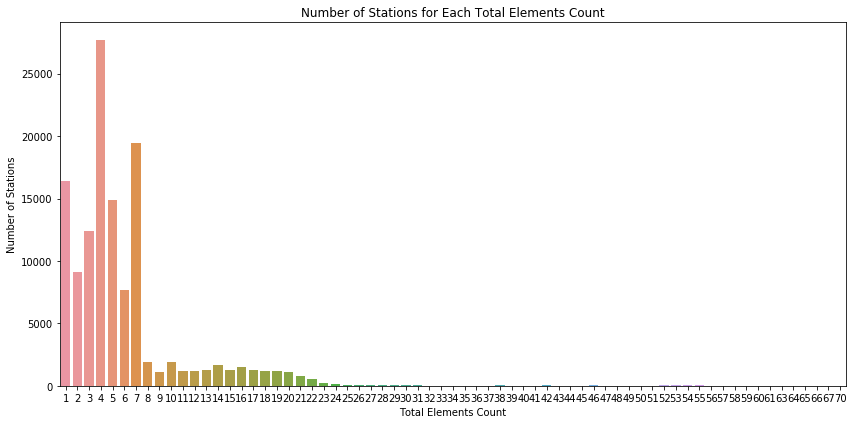

In [25]:
# Group by TotalElementsCount, count how many stations have each element count
stations_count_by_elements = total_elements_count_pdf.groupby('TotalElementsCount').size().reset_index(name='StationCount')

plt.figure(figsize=(12, 6))

# create the bar plot
sns.barplot(x='TotalElementsCount', y='StationCount', data=stations_count_by_elements)

# Set title and labels
plt.title('Number of Stations for Each Total Elements Count')
plt.xlabel('Total Elements Count')
plt.ylabel('Number of Stations')
plt.tight_layout()

plt.show()

Further, count separately the number of core elements and the number of ”other” elements
that each station has collected overall. How many stations collect all five core elements?
How many collect only precipitation and no other elements?


In [26]:
# Define core elements from README file
core_elements = ["PRCP", "TMAX", "TMIN", "SNOW", "SNWD"]
 
# Count distinct core elements
core_elements_df = inventory_df.filter(col("Element").isin(core_elements)) 

core_elements_count_df = core_elements_df.groupBy("ID").agg(
    countDistinct("Element").alias("CoreElementsCount")
)
 
# Count non-core elements
other_elements_count_df = inventory_df.filter(~col("Element").isin(core_elements)).groupBy("ID").agg(
    countDistinct("Element").alias("OtherElementsCount")
)
 
show_as_html(core_elements_count_df)
show_as_html(other_elements_count_df)
 

,ID,CoreElementsCount
0,ASN00023325,1
1,ASN00035062,1
2,ASN00042042,1
3,ASN00055135,1
4,ASN00082170,3
5,ASN00090184,3
6,BR037590830,1
7,BR048711080,1
8,CA001106P6N,3
9,CA003012872,3


,ID,OtherElementsCount
0,CA007077571,3
1,CA008400800,2
2,CA1ON000931,3
3,JAW00043313,14
4,KSW00043221,10
5,RQC00667297,4
6,RSM00028225,1
7,RSM00031295,1
8,USC00086753,11
9,USC00120132,8


In [27]:
# Count the number of stations that collected all five core elements
stations_all_core_elements_df = core_elements_count_df.filter(F.col("CoreElementsCount") == 5)

stations_all_core_elements_count = stations_all_core_elements_df.count() 
print(f"Number of stations that collected all five core elements: {stations_all_core_elements_count}")

# Filter only PRCP records
prcp_only_df = inventory_df.filter(F.col("Element") == "PRCP")

# Join the PRCP-only data
stations_only_prcp_df = prcp_only_df.join(total_elements_count_df, on="ID", how="inner") \
    .filter(col("TotalElementsCount") == 1)

# Count the number of such stations
stations_only_prcp_count = stations_only_prcp_df.count()
print(f"Number of stations that collected only precipitation (PRCP) and no other elements: {stations_only_prcp_count}")

Number of stations that collected all five core elements: 20482
Number of stations that collected only precipitation (PRCP) and no other elements: 16308


In [28]:
# Stations Q1step(e): enriched stations
enriched_stations_df = stations_states_joined \
    .join(first_last_year_df, "ID", "left") \
    .join(total_elements_count_df, "ID", "left") \
    .join(core_elements_count_df, "ID", "left") \
    .join(other_elements_count_df, "ID", "left") 

show_as_html(enriched_stations_df)

,ID,CountryCode,Latitude,Longitude,Elevation,State,Name,GSN_Flag,HCN_CRN_Flag,WMO_ID,CountryName,StateName,FirstYear,LastYear,TotalElementsCount,CoreElementsCount,OtherElementsCount
0,AGE00147719,AG,33.7997,2.8900,767.0,,LAGHOUAT,,,60545,Algeria,None,1888,2024,4,3,1.0
1,ALE00100939,AL,41.3331,19.7831,89.0,,TIRANA,,,,Albania,None,1940,2000,2,2,NaN
2,ARM00087480,AR,-32.9040,-60.7850,25.9,,ROSARIO,,,87480,Argentina,None,1965,2024,5,4,1.0
3,ASN00002033,AS,-17.8000,128.3000,-999.9,,TURNER RIVER,,,,Australia,None,1920,1965,1,1,NaN
4,ASN00004031,AS,-20.6267,117.1925,30.0,,POINT SAMSON,,,,Australia,None,1949,1983,4,1,3.0
5,ASN00006011,AS,-24.8878,113.6700,4.0,,CARNARVON AIRPORT,GSN,,94300,Australia,None,1750,2024,11,3,8.0
6,ASN00006023,AS,-23.8222,113.5256,20.0,,GNARALOO,,,,Australia,None,1912,2023,4,1,3.0
7,ASN00006077,AS,-25.3000,115.6000,-999.9,,BOUNDARY STORE,,,,Australia,None,1918,1928,1,1,NaN
8,ASN00007094,AS,-24.6514,116.1647,299.0,,YINNETHARRA,,,,Australia,None,1961,2021,4,1,3.0
9,ASN00007166,AS,-28.3500,116.5500,-999.9,,JOHARDO,,,,Australia,None,1911,1916,1,1,NaN


In [29]:
enriched_stations_df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- CountryCode: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Elevation: double (nullable = true)
 |-- State: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- GSN_Flag: string (nullable = true)
 |-- HCN_CRN_Flag: string (nullable = true)
 |-- WMO_ID: string (nullable = true)
 |-- CountryName: string (nullable = true)
 |-- StateName: string (nullable = true)
 |-- FirstYear: string (nullable = true)
 |-- LastYear: string (nullable = true)
 |-- TotalElementsCount: long (nullable = true)
 |-- CoreElementsCount: long (nullable = true)
 |-- OtherElementsCount: long (nullable = true)



In [30]:
# Save the DataFrame as a Parquet file for better efficiency
enriched_stations_df.write.mode("overwrite").parquet("./output/enriched_stations.parquet")
countries_df.write.mode("overwrite").parquet("./output/countries.parquet")
states_df.write.mode("overwrite").parquet("./output/states.parquet")
inventory_df.write.mode("overwrite").parquet("./output/inventory.parquet")

In [31]:
# Save the daily dataframe
daily_df.write.mode("overwrite").parquet("./output/daily.parquet")

In [32]:
! hdfs dfs -ls /user/yya163/output

Found 10 items
drwxr-xr-x   - yya163 yya163          0 2024-09-13 20:09 /user/yya163/output/avg_rainfall_by_country.csv
drwxr-xr-x   - yya163 yya163          0 2024-09-15 14:12 /user/yya163/output/countries.parquet
drwxr-xr-x   - yya163 yya163          0 2024-09-08 21:49 /user/yya163/output/countries_with_station_counts.parquet
drwxr-xr-x   - yya163 yya163          0 2024-09-15 14:24 /user/yya163/output/daily.parquet
drwxr-xr-x   - yya163 yya163          0 2024-09-15 14:12 /user/yya163/output/enriched_stations.parquet
drwxr-xr-x   - yya163 yya163          0 2024-09-15 14:12 /user/yya163/output/inventory.parquet
drwxr-xr-x   - yya163 yya163          0 2024-09-08 21:51 /user/yya163/output/nz_station_distances.parquet
drwxr-xr-x   - yya163 yya163          0 2024-09-15 14:12 /user/yya163/output/states.parquet
drwxr-xr-x   - yya163 yya163          0 2024-09-08 21:49 /user/yya163/output/states_with_station_counts.parquet
drwxr-xr-x   - yya163 yya163          0 2024-09-05 15:36 /user/yya163/o

## Stations:Q2

In [33]:
# Extract distinct station IDs from daily and stations
daily_station_ids_df = daily_df.select("ID").distinct()
station_ids_df = enriched_stations_df.select("ID").distinct()
 
# Count the number of missing stations
missing_station_ids_df = daily_station_ids_df.join(
    station_ids_df,
    daily_station_ids_df["ID"] == station_ids_df["ID"],
    "left_anti"
)

missing_station_count = missing_station_ids_df.count()
 
print(f"Number of stations in daily that are not in stations: {missing_station_count}")

Number of stations in daily that are not in stations: 0


In [62]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()